In [31]:
"""Sythetic-Data Exploration"""
# Authors: Lily Wu
#          Gaoyi Shi
#          Kecheng Xu
# License: Apache-2.0

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from scipy.sparse import issparse
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation
%matplotlib inline

"""
1. Purpose of this module:
   1. Generate sythetic transaction data, 
      customer document data(contains all transaction data of a specific customer).
      
   2. Explore the hidden customer pattern by the the models in our model pool 
      based on the generated customer document data.
   
   3. Model comparation
   
2. Usage of this module:
   1. Sytheti class: Sythetic
      including utility func: doc_final, count2vect, tfidf2vect,  
             model pool func: Kmeans, SVD, PCA, NMF, LDA, Auto-encoder
           visulization func: format_topics_sentences
                              Notes: it can generate topic_prediction, 
                                     prob_on_each_topic,
                                     most dominant words,
                                     most dominant customer for each cust class
                              
                              sub_plot_K(plot for each model)
                              
                              conf_mat(confusion matrix)
           
   2. Transaction class: txn_class
      including generating func: generat(generate single original txn)
    
   3. Customer class: cust_class
      including utility func: cust2doc(convert 2d-matrix to a single vect)
                              Notes: in 2d-matrix, each row is a single txn,
                                     all rows are all txn under a specific 
                                     customer
                              
                              pairwise(get two-order interactive-items) 
                              
             generating func: generat(generate all txn under a specific customer
                                      return a 2d-matrix)
"""
class Sythetic():
    def __init__(self):
        self.doc=[]
        self.label=[]
        self.count_mat=[[]]
        self.tfidf_mat=[[]]
        self.topics_df=[[]]
        
    def doc_final(self,cust_tuple,inter_items='one'):
        doc=[];label=[]
        for tuple_ in cust_tuple:
            for cust_num in range(tuple_[2]):
                tuple_[0].generat(tuple_[1])
                tuple_[0].cust2doc(inter_items)
                doc.append(tuple_[0].doc)
                label.append(tuple_[0].label)
        self.doc=doc;self.label=label
        return doc,label
    
    def count2vect(self,data=None):
        if data is None:
            data=self.doc
        count=CountVectorizer()
        sentence=[' '.join(i) for i in data]
        count_mat=count.fit_transform(sentence)
        self.count_mat=count_mat
        return count_mat
    
    def tfidf2vect(self,data=None):
        if data is None:
            data=self.doc
        tfidf=TfidfVectorizer()
        sentence=[' '.join(i) for i in data]
        tfidf_mat=tfidf.fit_transform(sentence)
        self.tfidf_mat=tfidf_mat
        return tfidf_mat
    
    def Kmeans(self,K,plt,data=None):
        if data is None:
            data=self.count_mat
        sse = {}
        t0=time()
        for k in tqdm(range(1, K+1)):
            kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
            sse[k] = kmeans.inertia_ 
        t1=time()
        plt.plot(list(sse.keys()), list(sse.values()))
        plt.set_title('Kmeans')
        plt.set_xlabel("Number of cluster")
        plt.set_ylabel("SSE")
        print('Kmeans running time:%f sec!'%(t1-t0))
        return sse
        
    def SVD(self,K,plt,data=None):
        if data is None:
            data=self.count_mat
        t0=time()
        svd=TruncatedSVD(n_components=K,n_iter=500,random_state=0)
        svd.fit(data)
        sigma=svd.singular_values_
        t1=time()
        x=[i for i in range(1,K+1)]
        plt.plot(x,sigma)
        plt.set_title('SVD')
        plt.set_xlabel("Singular Value Position")
        plt.set_ylabel("Singular Value")
        print('SVD running time:%f sec!'%(t1-t0))
        return sigma, svd.explained_variance_ratio_,svd.explained_variance_ratio_.sum()
        
    
    def PCA(self,K,plt,data=None):
        if data is None:
            data=self.count_mat
        sparse=issparse(data)
        t0=time()
        pca = PCA(n_components=K)
        if sparse:
            pca.fit(data.toarray())
        else:
            pca.fit(data)
        sigma=pca.singular_values_
        t1=time()
        x=[i for i in range(1,K+1)]
        plt.plot(x,sigma)
        plt.set_title('PCA')
        plt.set_xlabel("Singular Value Position")
        plt.set_ylabel("Singular Value")
        print('PCA running time:%f sec!'%(t1-t0))
        return sigma, pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum()
        
    def NMF(self,K,plt,data=None):
        if data is None:
            data=self.count_mat
        re = {}
        t0=time()
        for k in tqdm(range(1, K+1)):
            nmf = NMF(n_components=k, max_iter=1000).fit(data)
            re[k] = nmf.reconstruction_err_  
        t1=time()
        plt.plot(list(re.keys()), list(re.values()))
        plt.set_title('NMF')
        plt.set_xlabel("Number of cluster")
        plt.set_ylabel("Reconstruction-error")
        print('NMF running time:%f sec!'%(t1-t0))
        return re
    
    def LDA(self,K,plt,data=None):
        if data is None:
            data=self.doc
        t0=time()
        coherence_values = []
        data=[[str(word) for word in doc] for doc in data]
        id2word=corpora.Dictionary(data)
        corpus = [id2word.doc2bow(text) for text in data]
        for num_topics in tqdm(range(1,K+1)):
            model=gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics=num_topics, 
                                                   chunksize=30,
                                                   passes=5,
                                                   random_state=100) 
            coherencemodel = CoherenceModel(model=model, texts=data, dictionary=id2word, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
        t1=time()
        x=[i for i in range(1,K+1)]
        plt.plot(x,coherence_values)
        plt.set_title('LDA')
        plt.set_xlabel("Number of cluster")
        plt.set_ylabel("Coherence score")
        print('LDA running time:%f sec!'%(t1-t0))
        return coherence_values
    
    def format_topics_sentences(self,ldamodel, corpus, texts):
        # Init output
        sent_topics_df = pd.DataFrame()

        # Get main topic in each document
        for i, row_list in enumerate(ldamodel[corpus]):
            row = row_list[0] if ldamodel.per_word_topics else row_list            
            # print(row)
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

        # Add original text to the end of the output
        contents = pd.Series(texts)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
        return(sent_topics_df)# return a df
    
    def sub_plot_K(self,K,data=None,doc=None):
        if data is None:
            data=self.count_mat
        if doc is None:
            doc=self.doc
        fig = plt.figure(figsize=(18,10))
        ax1=fig.add_subplot(231)
        self.Kmeans(K,ax1,data)
        ax2=fig.add_subplot(232)
        self.SVD(K,ax2,data)
        ax3=fig.add_subplot(233)
        self.PCA(K,ax3,data)
        ax4=fig.add_subplot(234)
        self.NMF(K,ax4,data)
        ax5=fig.add_subplot(235)
        self.LDA(K,ax5,doc)
        plt.show()

    def Kmeans_pred(self,K,real_label=None,data=None):
        if data is None:
            data=self.count_mat
        if real_label is None:
            real_label=self.label
        kmeans=KMeans(n_clusters=K,max_iter=1000)
        kmeans_pred=kmeans.fit_predict(data)
        conf_mat=confusion_matrix(real_label,kmeans_pred)
        return kmeans_pred,conf_mat
    
    def NMF_pred(self,K,real_label=None,data=None):
        if data is None:
            data=self.count_mat
        if real_label is None:
            real_label=self.label
        nmf=NMF(n_components=K, max_iter=1000)
        W=nmf.fit_transform(data)
        nmf_pred=[np.argmax(i) for i in W]
        conf_mat=confusion_matrix(real_label,nmf_pred)
        return nmf_pred,conf_mat
    
    def LDA_pred(self,K,real_label=None,data=None):
        if data is None:
            data=self.doc
        if real_label is None:
            real_label=self.label
        data=[[str(word) for word in doc] for doc in data]
        id2word=corpora.Dictionary(data)
        corpus = [id2word.doc2bow(text) for text in data]
        model=gensim.models.ldamodel.LdaModel(id2word=id2word,
                                        num_topics=3,
                                        corpus=corpus,
                                        chunksize=100,
                                        passes=10,
                                        random_state=100)
          
        df_topic_sents_keywords = self.format_topics_sentences(ldamodel=model, corpus=corpus, texts=data)
        df_dominant_topic = df_topic_sents_keywords.reset_index()
        df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
        LDA_pred=df_dominant_topic['Dominant_Topic']
        conf_mat=confusion_matrix(real_label,LDA_pred)
        self.topics_df=df_dominant_topic
        return LDA_pred,conf_mat,df_dominant_topic
    
    
    def conf_mat(self,K,real_label=None,data=None,doc=None):
        if data is None:
            data=self.count_mat
        if doc is None:
            doc=self.doc
        if real_label is None:
            real_label=self.label
        print('*********K-means*********')
        print(self.Kmeans_pred(K,real_label,data)[1])
        print('*********NMF*************')
        print(self.NMF_pred(K,real_label,data)[1])
        print('*********PCA*************')
        print(self.Kmeans_pred(K,real_label,PCA(K).fit_transform(data.toarray()))[1])
        print('*********SVD**************')
        print(self.Kmeans_pred(K,real_label,TruncatedSVD(K).fit_transform(data))[1])
        print('*********LDA**************')
        print(self.LDA_pred(K,real_label,doc)[1])  
        
s=Sythetic()

In [32]:
class txn_class():
    def __init__(self,feat_num,feat_prob):
        if (len(feat_prob)!=feat_num):
            print('The feature number does not match the prob length!')
            raise ValueError
        self.feat_num=feat_num
        self.feat_prob=feat_prob
    
    def generat(self):
        txn=[]
        for feat in range(self.feat_num):
            feat_data=np.random.choice(len(self.feat_prob[feat]),
                                       1,p=self.feat_prob[feat])
            txn.extend(feat_data)
        return txn

In [33]:
class cust_class():
    def __init__(self,label,*txn_class_pool):
        self.label=label
        self.txn_class_pool=txn_class_pool
        self.txn_mat=[]
        self.inter_items='one'
        self.doc=[]
    
    def generat(self,each_txn_class_amt=[5,5]):
        if (len(self.txn_class_pool)!=len(each_txn_class_amt)):
            print('Txn_class does not match!')
            raise ValueError
        txn_mat=[]
        for idx,txn_class in enumerate(self.txn_class_pool):
            txn_mat.extend([txn_class.generat() for i in range(each_txn_class_amt[idx])])
        self.txn_mat=txn_mat
        return txn_mat
  
    def pairwise(self,txn_mat):
        mat=[]
        for s in txn_mat:
            row=[]
            for i in range(len(s)-1):
                for j in range(i+1,len(s)):
                    row.append(s[i]+'_'+s[j])
            mat.append(row)
        return mat 
    
    def cust2doc(self,inter_items='one'):
        self.inter_items=inter_items
        inter_1=[[str(idx)+'_'+str(j) for idx,j in enumerate(i) ]for i in self.txn_mat]
        
        if inter_items=='one':
            for i in inter_1:
                self.doc.extend(i)
            return self.doc
        
        elif inter_items=='two':
            inter_2=self.pairwise(inter_1)
            inter_2_np=np.array(inter_2)
            inter_1_np=np.array(inter_1)
            inter_2_1_np=np.append(inter_1_np,inter_2_np,axis=1)
            self.doc=inter_2_1_np.flatten()
            return self.doc
        
        elif inter_items=='full':
            inter_2=self.pairwise(inter_1) 
            inter_1_np=np.array(inter_1) 
            inter_2_np=np.array(inter_2)
            inter_2_1_np=np.append(inter_1_np,inter_2_np,axis=1)
            inter_full=[[str(j) for j in i]for i in self.txn_mat]
            inter_full=['_'.join(i) for i in inter_full]
            inter_full=[[i] for i in inter_full]
            inter_full_np=np.array(inter_full)
            inter_full_2_1_np=np.append(inter_2_1_np,inter_full_np,axis=1)
            self.doc=inter_full_2_1_np.flatten()
            return self.doc
            
        else:
            return None
        

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  7.72s/it]


Kmeans running time:68.213278 sec!
SVD running time:10.140032 sec!
PCA running time:0.196158 sec!


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  8.26s/it]


NMF running time:53.547911 sec!


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:20<00:00, 27.50s/it]


LDA running time:261.330068 sec!


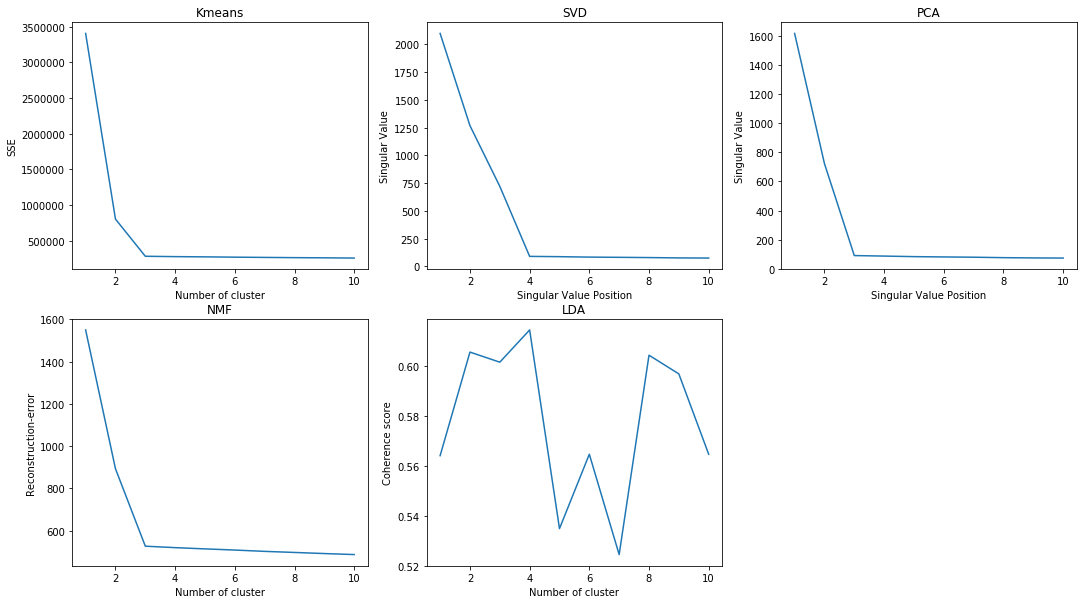

*********K-means*********
[[ 0  0 50]
 [50  0  0]
 [ 0 50  0]]
*********NMF*************
[[ 0  0 50]
 [ 0 50  0]
 [50  0  0]]
*********PCA*************
[[ 0  0 50]
 [50  0  0]
 [ 0 50  0]]
*********SVD**************
[[ 0 50  0]
 [ 0  0 50]
 [50  0  0]]
*********LDA**************
[[ 0 50  0]
 [50  0  0]
 [ 0  0 50]]


In [38]:
# 5 is original feature number, each feature can take value from 0-9
# 5 original feature can be:
## txn_amt:0-9,
## txn_type:0-9,
## txn_paymt:0-9,
## txn_recorpay:0-9,
## txn_bene:0-9

# the matrix with shape 5*10. 
## Apparenty, each row is the distribution on items 0-9 for each features
## So t1..t7 is txn_class which contains the info of this txn_class
### However, when you create t1..t7, you just create an instance of txn_class, but not a real txn.
### You have to use txn_class fuc generat to really generate a single txn 
### which will be trigered in doc.final func in Sythetic class afterwards.
### all txn will be only generated when you use doc.final in Sythetic class. 
### Before that, you only set up txn and customer instance containing all info of txn and cust you need.

t1=txn_class(5,[[.9,.1,.0,.0,.0,.0,.0,.0,.0,.0], #single-pattern
               [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1],
               [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1],
               [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1],
               [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]])

t2=txn_class(5,[[.1,.9,.0,.0,.0,.0,.0,.0,.0,.0], #two-order interactive-items
               [.9,.1,.0,.0,.0,.0,.0,.0,.0,.0],
               [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1],
               [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1],
               [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]])

t3=txn_class(5,[[.1,.1,.1,.1,.1,.1,.1,.1,.1,.1], #two-order interactive-items
               [.1,.0,.0,.0,.1,.0,.1,.0,.7,.0],
               [.1,.0,.0,.0,.1,.1,.1,.6,.0,.0],
               [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1],
               [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]])

t4=txn_class(5,[[.1,.1,.1,.1,.1,.1,.1,.1,.1,.1],#three-order interactive-items
                [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1],
                [.0,.0,.0,.0,.1,.8,.1,.0,.0,.0],
                [.0,.0,.0,.0,.0,.1,.8,.1,.0,.0],
                [.0,.0,.0,.0,.0,.0,.1,.8,.1,.0]])

t5=txn_class(5,[[.0,.0,.9,.0,.0,.0,.0,.0,.0,.1],#full-order interactive-items
                [.1,.0,.9,.0,.0,.0,.0,.0,.0,.0],
                [.0,.0,.9,.0,.0,.1,.0,.0,.0,.0],
                [.0,.0,.0,.0,.9,.0,.0,.1,.0,.0],
                [.0,.0,.0,.0,.9,.0,.1,.0,.0,.0]])

t6=txn_class(5,[[.0,.0,.8,.0,.0,.1,.0,.0,.0,.1],#full-order interactive-items
                [.1,.0,.9,.0,.0,.0,.0,.0,.0,.0],
                [.0,.0,.7,.1,.0,.1,.1,.0,.0,.0],
                [.1,.0,.1,.0,.7,.0,.0,.1,.0,.0],
                [.1,.0,.1,.0,.1,.0,.1,.0,.6,.0]])

t7=txn_class(5,[[.1,.1,.1,.1,.1,.1,.1,.1,.1,.1],#random sample
                [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1],
                [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1],
                [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1],
                [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]])

## You set up three customer class c1, c2, c3
## c1: label-class0, this kind of cust has three types of txn, t1,t2,t7
## c2: label-class1, this kind of cust has three types of txn, t3,t4,t7
## c3: label-class2, this kind of cust has three types of txn, t5,t6,t7
## Again, c1..c3 is only instance without real generated data. Data will only
## be generated when you set up and use doc_final func in Sythetic class.
## and the customer_doc, label, word_count_matrix info will be the self attributes of Sythetic instance.

c1=cust_class(0,t1,t2,t7)
c2=cust_class(1,t3,t4,t7)
c3=cust_class(2,t5,t6,t7)

## doc_final is the most important func in this module.
## The input arguments is as following:
## a list contains info for each cust_class: for instance,
## (c1,[50,50,50],50) means generate a cust_class:c1, since c1 has three types of txn-
## t1,t2,t7. each txn number is in the list [50,50,50], meaning generating 50 txn individually for t1,t2,t7.
## Notice that even a customer has only a single txn class, you need to use a list [50] here!
## he last 50 means generate 50 customers for c1.
## So on and so forth, generate c2 and c3 like c1.
## last argument 'full' means using full interactive-items to generate words

s.doc_final([(c1,[50,50,50],50),(c2,[50,50,50],50),(c3,[50,50,50],50)],'full') # c1,c2,c3 is customer class, [100] is txn_num, 50 is custmoer_num
s.count2vect()
s.sub_plot_K(10)
s.conf_mat(3)

In [39]:
s.topics_df

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9996,"0_1, 1_0, 0_0, 0_1_1_0, 4_4, 3_9, 2_7, 4_6, 3_...","[0_0, 1_4, 2_2, 3_9, 4_6, 0_0_1_4, 0_0_2_2, 0_..."
1,1,1.0,0.9873,"0_1, 1_0, 0_0, 0_1_1_0, 4_4, 3_9, 2_7, 4_6, 3_...","[0_0, 1_9, 2_4, 3_1, 4_1, 0_0_1_9, 0_0_2_4, 0_..."
2,2,1.0,0.9957,"0_1, 1_0, 0_0, 0_1_1_0, 4_4, 3_9, 2_7, 4_6, 3_...","[0_0, 1_6, 2_6, 3_4, 4_2, 0_0_1_6, 0_0_2_6, 0_..."
3,3,1.0,0.9915,"0_1, 1_0, 0_0, 0_1_1_0, 4_4, 3_9, 2_7, 4_6, 3_...","[0_0, 1_3, 2_7, 3_9, 4_4, 0_0_1_3, 0_0_2_7, 0_..."
4,4,1.0,0.9835,"0_1, 1_0, 0_0, 0_1_1_0, 4_4, 3_9, 2_7, 4_6, 3_...","[0_0, 1_6, 2_7, 3_8, 4_7, 0_0_1_6, 0_0_2_7, 0_..."
5,5,1.0,0.9975,"0_1, 1_0, 0_0, 0_1_1_0, 4_4, 3_9, 2_7, 4_6, 3_...","[0_0, 1_8, 2_8, 3_5, 4_3, 0_0_1_8, 0_0_2_8, 0_..."
6,6,1.0,0.9792,"0_1, 1_0, 0_0, 0_1_1_0, 4_4, 3_9, 2_7, 4_6, 3_...","[0_0, 1_9, 2_4, 3_7, 4_1, 0_0_1_9, 0_0_2_4, 0_..."
7,7,1.0,0.9997,"0_1, 1_0, 0_0, 0_1_1_0, 4_4, 3_9, 2_7, 4_6, 3_...","[0_0, 1_1, 2_1, 3_3, 4_1, 0_0_1_1, 0_0_2_1, 0_..."
8,8,1.0,0.9965,"0_1, 1_0, 0_0, 0_1_1_0, 4_4, 3_9, 2_7, 4_6, 3_...","[0_0, 1_5, 2_3, 3_3, 4_8, 0_0_1_5, 0_0_2_3, 0_..."
9,9,1.0,0.9962,"0_1, 1_0, 0_0, 0_1_1_0, 4_4, 3_9, 2_7, 4_6, 3_...","[0_0, 1_6, 2_5, 3_4, 4_2, 0_0_1_6, 0_0_2_5, 0_..."
